In [1]:
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import cv2
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras import backend as K
K.set_image_data_format('channels_last')
import argparse
import os
import sys


Using TensorFlow backend.


#### Training image files are listed in a CSV along with the corresponding throttle, gear and normalized steering angle values as calculated by the simulator. Images are loaded by using a pandas data frame. 

#### Load CSV file generated from Unity Car Simulation GUI

In [2]:
image_path = '/Users/Santhosh/Desktop/PatternRecognition/Project/'
filename = 'driving_log_train_filt.csv'
filepath = image_path + filename
df = pd.read_csv(filepath).dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15065 entries, 0 to 15064
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   center    15065 non-null  object 
 1   left      15065 non-null  object 
 2   right     15065 non-null  object 
 3   steering  15065 non-null  float64
 4   throttle  15065 non-null  float64
 5   gear      15065 non-null  float64
 6   speed     15065 non-null  float64
dtypes: float64(4), object(3)
memory usage: 941.6+ KB


In [3]:
def Img_concat(im1path, im2path,im3path):
    im1 = Image.open(im1path)
    im2 = Image.open(im2path)
    im3 = Image.open(im3path)
    dst = Image.new('RGB', (im1.width + im2.width+im3.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    dst.paste(im3,(im1.width+im2.width,0))
    return dst

In [ ]:
##Run this  part only once so that concat images will get generated in IMG path then comment it back.
#from PIL import Image
#for index, row in df.iterrows(): 
#    Img_concat(row['left'],row['center'],row['right']).save(image_path+'/Users/Santhosh/Desktop/PatternRecognition/Project/IMG/'+str(index)+'.jpg')


In [4]:
df.reset_index(inplace=True)
df['lcr']='IMG/'+ df['index'].astype('str')+'.jpg'

## provide img path instead of IMG if it is present in different folder

#### Response vector for the CNN to predict is normalized steering angle. "X" is an array of strings containing the filename for each image of three cameras for each corresponding steering angle, along the track. 

In [5]:
#Use Pandas to split images from all three cameras into training and test sets 
#First test validation is performed with a subset of training images from the first two laps with the "Lakeside" track
#as generated from the Unity car simulator. 
#The model is saved at the end, and is loaded to run the prediction on a separate set of images to valid its accuracy on the "Jungle" track.
#X = df[['center','left','right']].values
#y = df['steering'].values
X = df[['lcr']].values
y = df['steering'].values

#### Split the data set for an 80% training partitions, and a 20% test partition. 

In [6]:
#Split images into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [7]:
#Test code to validate the camera view randomization, image crop functions with OpenCV & conversion from RGB to YUV 
#This is here to show how the batch generation functions are loading the input images, and visually what they look
#like before being passed into the CNN 
img = plt.image.imread(image_path + X_test[0][0]) #read in first image to extract "input_shape" and initialize image subset arrays
x_size = 600 #number of columns within input image
y_size = 66 #number of rows within input image 
#cropimg = cv2.resize(img,(x_size,y_size)) #crop the image to 66x200x3 as in Nvidia's CNN for steering angle prediction
x1 = int(img.shape[1]/2 - x_size/2)
x2 = int(img.shape[1]/2 + x_size/2)
y1 = int(img.shape[0]/2 - y_size/2)
y2 = int(img.shape[0]/2 + y_size/2)
cropimg = img[y1:y2, x1:x2]
yuvimg = cv2.cvtColor(cropimg, cv2.COLOR_BGR2YUV) #convert to YUV from RGB input
print(img.shape)
print(cropimg.shape)
X_test_crop = np.zeros((X_test.shape[0]*X_test.shape[1],y_size,x_size,img.shape[2]),dtype='int')
print(X_test_crop.shape)
output_shape = yuvimg.shape #global image shape used for all model initializations 
print(output_shape)

(160, 960, 3)
(66, 600, 3)
(3013, 66, 600, 3)
(66, 600, 3)


In [8]:
img.shape

(160, 960, 3)

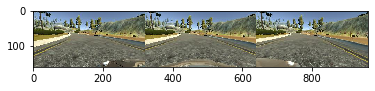

In [9]:
#Show an example before cropping
plt.pyplot.imshow(img)

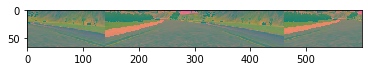

In [10]:
#Show the cropped YUV image. All features are left within the image to ensure most of the road is in the image
#Other tracks have hills and different terrain, so cropping out the sky could inadvertently affect validation
#on later image sets. 
plt.pyplot.imshow(yuvimg)

### Functions to augment a subset of the images

In [11]:
def horiz_flip(img, steer_ang):
    ret_val = (cv2.flip(img,1), -steer_ang)
    return ret_val

def image_darkening(img, low=0.6, high=0.9):
    img = img.astype(np.float32)
    scalar = np.random.uniform(low, high)
    img = scalar*img
    
    return img.astype(np.uint8)

def add_shadow(img, low=0.4, high=0.7):
    cols, rows = (img.shape[0], img.shape[1])
    
    top_y = np.random.random() * rows
    bottom_y = np.random.random() * rows
    bottom_y_right = bottom_y + np.random.random() * (rows - bottom_y)
    top_y_right = top_y + np.random.random() * (rows - top_y)

    bottom_offset = np.random.uniform(cols,cols*.7)
    top_offset = np.random.uniform(0.5*cols,0.35*cols)

    if np.random.random() <= 0.5:
        bottom_y_right = bottom_y - np.random.random() * (bottom_y)
        top_y_right = top_y - np.random.random() * (top_y)
    
    poly = np.asarray([[ [top_y,top_offset], [bottom_y, bottom_offset], [bottom_y_right, bottom_offset], [top_y_right,top_offset]]], dtype=np.int32)
        
    mask_weight = np.random.uniform(low, high)
    origin_weight = 1 - mask_weight
    
    mask = np.copy(img).astype(np.int32)
    cv2.fillPoly(mask, poly, (0,0,0))

    return cv2.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

def rand_shifts(img, steer_ang):
    rows, cols = (img.shape[0], img.shape[1])
    x_shift = np.random.randint(-50, 50) 
    y_shift = np.random.randint(-10, 10) 
    
    # Change steer angle based off horizontal shift
    steer_ang += x_shift * (.35/100)
    translation_matrix = np.float32([[1, 0, x_shift],[0, 1, y_shift]])
    img = cv2.warpAffine(img, translation_matrix, (cols, rows))
    
    return img, steer_ang

def augment_image(img, steer_ang):
    
    #probability of each change
    p1 = .3
    p2 = .05
    p3 = .1
    p4 = .3

    if np.random.random() <= p1: 
        img, steer_ang = horiz_flip(img, steer_ang)
     
    if np.random.random() <= p2:
        img = image_darkening(img)
    
    if np.random.random() <= p3: 
        img = add_shadow(img)
            
    if np.random.random() <= p4:
        img, steer_ang = rand_shifts(img, steer_ang)
            
    return img, steer_ang

def fix_steer(steer_ang,cam_choice):
    ang_offset = [0, 0.25, -0.25]
    return steer_ang + ang_offset[cam_choice]

In [12]:
#Bound by limits of sample input - returns an array of jpegs & array of corresponding steering angles for each image
#Samples defines the total number of images fed through the CNN for one epoch
#by randomly selecting a tuple (bound by size(X_train)) and 0,1,2, with 0 being center camera, 1 being left, 2 being right
#The Keras CNN Sequential model doesn't know if input images comes fromm the center left, or right camera, this is to 
#add some randomization to the training process before calling "DataGenerator", which performs
#additional randomization steps to each input frame, then images are passed into the model 
#Images are loaded with matplotlib libraries as numpy arrays one by one
#Images are cropped to the 66x200x3 and returned to the CNN  

def image_subset(X_train,y_train,samples):
    #User must input number of images to be pulled at random from the input dataframe pointing to where images are stored
    img = plt.image.imread(image_path + X_train[0][0]) #read in first image to extract "input_shape" and initialize image subset arrays
    size = [66,600]
    x_size = 600 #number of desired columns within input image to CNN
    y_size = 66 #number of desired rows within input image 
    output_shape = (*size,img.shape[2])
    X_train_sub = np.zeros((samples,y_size,x_size,img.shape[2]),dtype='int')
    y_train_sub = np.zeros(samples,dtype='float')
    #randvec = np.random.randint(0,X_train.shape[0],samples) #generate a vector of random image tuples as a numpy array
    cam_choice = np.random.randint(0,X_train.shape[1],samples) #vector for random camera choice
    #Load images into 4D numpy array of RGB images, randomly sampling the image directory by tuple and camera choice
    #Size of array to be passed into Keras is (samples,66,200,3)
    for index in range(samples):
        i = np.random.randint(0,X_train.shape[0])#randvec[index]
        j = cam_choice[index]
        fname = image_path + X_train[i][j] #string containing path to image 
        img = plt.image.imread(fname) #read in full image
        
        # Augment image and steering as needed 
        aug_steer = fix_steer(y_train[i], j)
        aug_image, aug_steer = augment_image(img, aug_steer)# Randomly add chance of shadow, flipping image, etc.
        
        currimg = aug_image[40:420,:,:]
        cropimg = cv2.resize(currimg,(x_size,y_size)) #crop currently selected random image
        yuvimg = cv2.cvtColor(cropimg, cv2.COLOR_BGR2YUV) #convert RGB to YUV format
        
        X_train_sub[index,:,:,:] = yuvimg
        y_train_sub[index] = aug_steer
        del currimg
        del yuvimg
        
    #Drop some amount of examples with steering angle close to zero
    temp_X = []
    temp_y = []
    p_drop = 0.1
    for index in range(y_train_sub.shape[0]):
        if abs(y_train_sub[index]) > .05  \
           or np.random.random() > p_drop:
            temp_X.append(X_train_sub[index])
            temp_y.append(y_train_sub[index])
    X_train_sub = np.array(temp_X)
    y_train_sub = np.array(temp_y)
    
    return X_train_sub,y_train_sub

#Test set is returned to the model evaluation using all camera views and associated steering angle for that image
#All images are returned to be tested with the model, not cropped as for the randomized subset of each epoch
def crop_test_set(X_test,y_test):
    img = plt.image.imread(image_path + X_test[0][0]) #read in first image to extract "input_shape" and initialize image subset arrays
    x_size = 600 #number of desired columns within input image to CNN
    y_size = 66 #number of desired rows within input image 
    X_test_crop = np.zeros((X_test.shape[0],y_size,x_size,img.shape[2]),dtype='int')
    y_test_crop = np.zeros(X_test.shape[0],dtype='float')
    for index in range(X_test.shape[0]):
        i = index
        fname = image_path + X_train[i][0] #string containing path to image for center camera
        img = plt.image.imread(fname) #read in full image
        currimg = img[40:420,:,:]
        cropimg = cropimg = cv2.resize(currimg,(x_size,y_size)) #crop currently selected random image
        yuvimg = cv2.cvtColor(cropimg, cv2.COLOR_BGR2YUV) #convert RGB to YUV format 
        X_test_crop[i,:,:,:] = yuvimg
        y_test_crop[i] = y_test[i]
        del currimg
        del yuvimg
    return X_test_crop,y_test_crop

#### Initialization of model parameters for Keras
#### Adam is the optimizer of choice during back propagation
#### Reference suggests to use "Elu" as the activation function of choice to run training. If times permits, we will also check performance of the sigmoid and ReLu, although the sigmoid will naturally suppress some of the connection weights due to the vainishing gradient problem, that the other aforementioned activation functions are used to avoid. 
#### Batch size of 32 seems to be a good choice for CNN training from our references we've been exploring

In [13]:
#Pre-define model input parameters - global constants called by CNN training 
batch_size = 40
epochs = 10
activ_fs = 'elu' #list holding different activation functions to test on Nvidia model
keep_prob = 0.5 #drop out parameter 
data_augmentation = True
learning_rate = 0.0001 #1e-4 as in Shibuya-san's study with Keras 
samples = len(X_train) #number of images fed through the CNN per epoch
save_dir = image_path+'saved_models'
#Check if directory where model is saved already exists
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
base_name = 'keras_nvidia_trained_model_active_f='
#Test model name convention 
model_name = base_name + activ_fs + '_batch_size=' + str(batch_size) + 'run_three.h5'
print(model_name)
print(save_dir + '/' + model_name)

keras_nvidia_trained_model_active_f=elu_batch_size=40run_three.h5
/Users/Santhosh/Desktop/PatternRecognition/Project/saved_models/keras_nvidia_trained_model_active_f=elu_batch_size=40run_three.h5


In [14]:
#Model function based on the Nvidia CNN Sequential model for steering angle prediction
#Modified version of Kishibuya-san's code, adapted to Keras 2 to match the same output size as Nvidia's CNN Architecture
#Nvidia's normalization procedure (Lambda) is not disclosed - argument is used as in the provided source (Shibuya-san)
#Output size at each step matches the Nvidia flow
def model_generator(activ_f,output_shape):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape = output_shape)) #normalization layer is fixed for all experiments
    model.add(Conv2D(24,(5,5),strides=(2,2),activation=activ_f))
    model.add(Conv2D(36,(5,5),strides=(2,2),activation=activ_f))
    model.add(Conv2D(48,(5,5),strides=(2,2),activation=activ_f))
    model.add(Conv2D(64,(3,3), activation=activ_f))
    model.add(Conv2D(64,(3,3), activation=activ_f))
    model.add(Dropout(keep_prob))
    model.add(Flatten())
    model.add(Dense(100, activation=activ_f))
    model.add(Dense(50, activation=activ_f))
    model.add(Dense(10, activation=activ_f))
    model.add(Dense(1))
    model.summary()
    return model

#### Keras ImageDataGenerator - will be expanding this to include more image randomization features, e.g., shadow inclusion.

In [15]:
#Section for training and initializing the batch data modifier, which applies random pixel shifts and image translations
#DataGenerator calls image_subset which selects 
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

#### Keras ImageDataGenerator - will be expanding this to include more image randomization features, e.g., shadow inclusion.

In [16]:
#Run model training, return image subset defined by desired number of samples per epoch
import time
start_time = time.time()
#Initialize data matrix storing the MSE of each epoch for training and test 
train_loss_all_elu = np.zeros(epochs,dtype='float')
val_loss_all_elu = np.zeros(epochs,dtype='float')
#Initialize a randomized set of images for training
x_train_sub,y_train_sub = image_subset(X_train,y_train,batch_size)
#Retun the test set once, to be evaluated on each model with different batch sizes
x_test_sub,y_test_sub = crop_test_set(X_test,y_test)
activ_f = activ_fs
batch_s = batch_size
#Initialize Nvidia CNN architecture for input activation function and batch_size
model = model_generator(activ_f,output_shape)  
print('Current batch size is ',batch_s)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 600, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 298, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 147, 36)       21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 72, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 70, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 68, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 68, 64)        

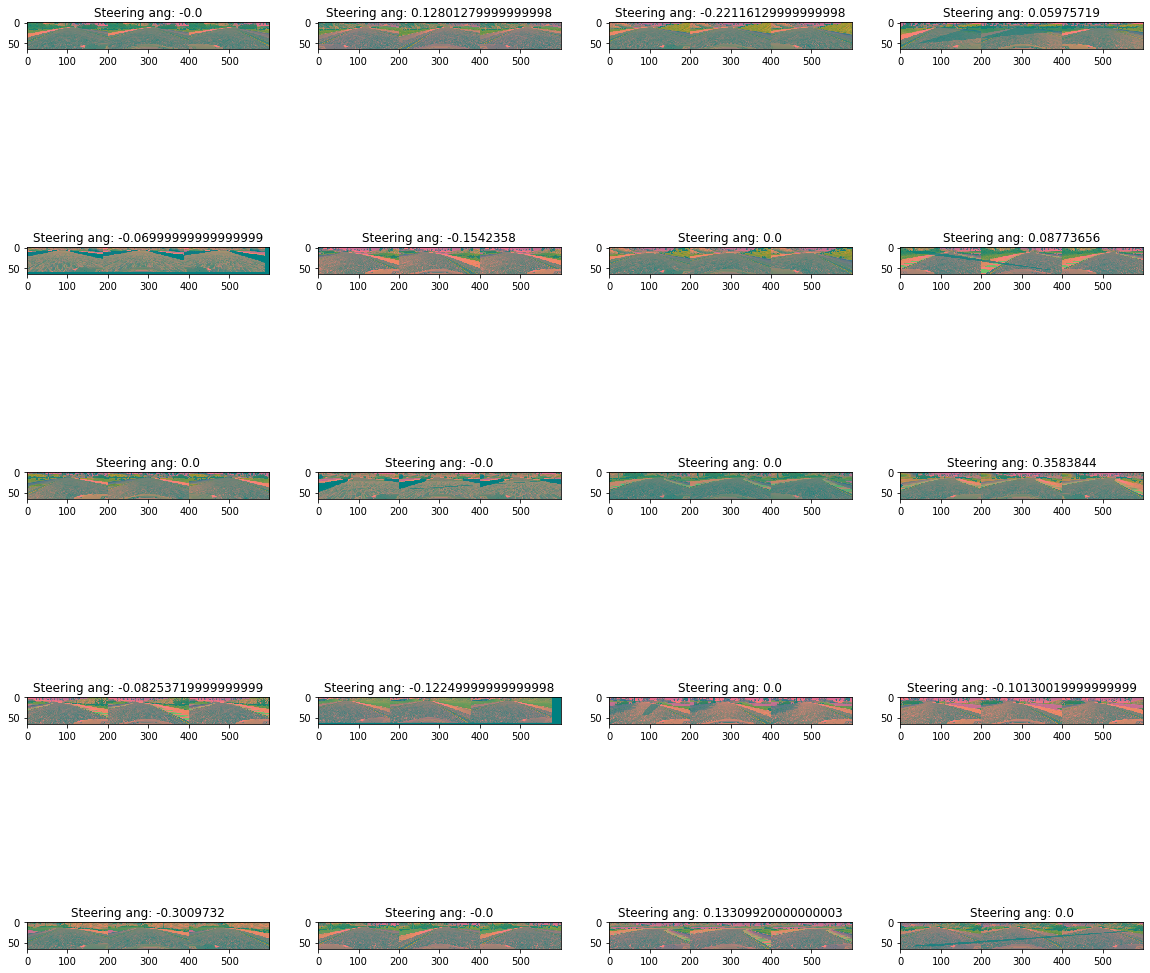

In [17]:
w=10
h=10
fig=plt.pyplot.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.pyplot.imshow(x_train_sub[i])
    plt.pyplot.title("Steering ang: " + str(y_train_sub[i]))
plt.pyplot.show()

In [18]:
#Loss monitoring is MSE (angle^2 for steering), Adam is a modified SGD algorithm
del x_train_sub, y_train_sub
model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))
history = model.fit_generator(datagen.flow(image_subset(X_train,y_train,batch_s),
                                     batch_size=batch_s),
                        steps_per_epoch = samples/batch_s,
                        epochs=epochs,
                        validation_data=(x_test_sub, y_test_sub))
train_loss_all_elu[:,] = history.history['loss']
val_loss_all_elu[:,] = history.history['val_loss']
#Save current model to the save directory, for future testing
model_name = base_name + activ_f + '_batch_size=' + str(batch_s) + '.h5'
model.save(save_dir + '/' + model_name) #save current model
del model #clear model from the workspace after finishing save operation
stop_time = time.time()
print("Required time to calculate for given samples and total epochs is :",stop_time-start_time)

Epoch 1/10
302/301 [==============================] - 304s 1s/step - loss: 0.0230 - val_loss: 0.0163
Epoch 2/10
302/301 [==============================] - 336s 1s/step - loss: 0.0170 - val_loss: 0.0148
Epoch 3/10
302/301 [==============================] - 316s 1s/step - loss: 0.0155 - val_loss: 0.0173
Epoch 4/10
302/301 [==============================] - 328s 1s/step - loss: 0.0148 - val_loss: 0.0163
Epoch 5/10
302/301 [==============================] - 331s 1s/step - loss: 0.0140 - val_loss: 0.0171
Epoch 6/10
302/301 [==============================] - 308s 1s/step - loss: 0.0133 - val_loss: 0.0191
Epoch 7/10
302/301 [==============================] - 352s 1s/step - loss: 0.0121 - val_loss: 0.0185
Epoch 8/10
302/301 [==============================] - 351s 1s/step - loss: 0.0115 - val_loss: 0.0188
Epoch 9/10
302/301 [==============================] - 416s 1s/step - loss: 0.0106 - val_loss: 0.0198
Epoch 10/10
302/301 [==============================] - 347s 1s/step - loss: 0.0100 - val_lo

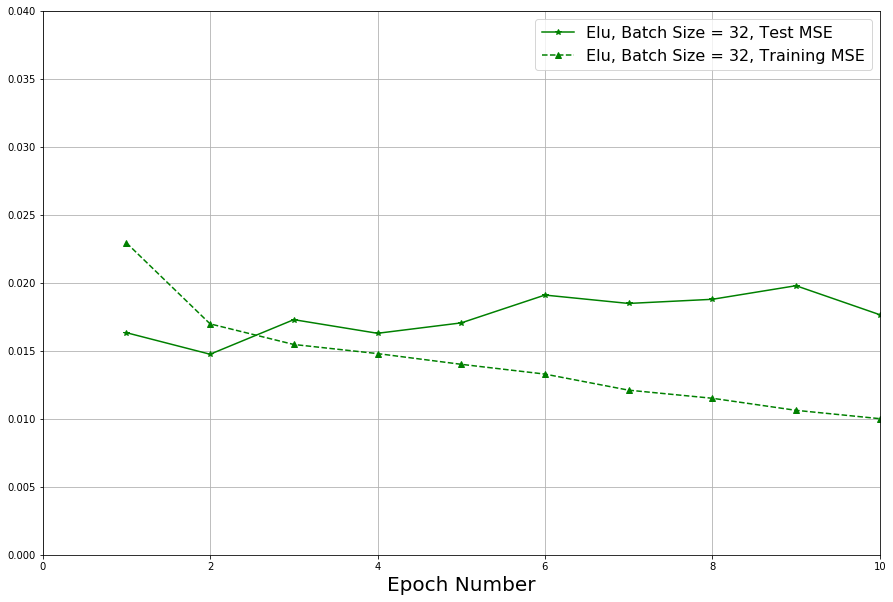

In [19]:
train_loss_all_elu.shape
val_loss_all_elu.shape
#Save training and test MSE to directory where models are stored from the previous step, for each activation function
np.savetxt(save_dir+'/'+'test_mse_elu.out',val_loss_all_elu[:,], delimiter=',') 
np.savetxt(save_dir+'/'+'train_mse_elu.out',train_loss_all_elu[:,], delimiter=',') 
#For all investigated activation functions (ELu, ReLU & Sigmoid), plot training and test MSE (angle^2)
#for each investigated batch size. 
samples = np.linspace(1,epochs,epochs)
fig,axs = plt.pyplot.subplots(1,1,figsize=(15,10))
#Fixed axes for all plots
V = [0, 10, 0, 0.04]
#Subplot for Elu training and test (validation) MSE
axs.plot(samples,val_loss_all_elu[:,],color="g",marker='*',label="Elu, Batch Size = 32, Test MSE")
axs.plot(samples,train_loss_all_elu[:,],color="g",marker='^',linestyle='dashed',
            label="Elu, Batch Size = 32, Training MSE")
axs.legend(loc="upper right",fontsize=16)
axs.axis(V)
axs.grid(True)
plt.pyplot.xlabel('Epoch Number', fontsize = 20)
plt.pyplot.show()

In [20]:
from keras.models import load_model
model = load_model(save_dir + '/' + model_name)
y_pred = model.predict(x_test_sub,verbose=1)
print(y_pred)

3013/3013 [==============================] - 16s 5ms/step
[[-0.06824441]
 [-0.09504383]
 [ 0.00325264]
 ...
 [-0.02236237]
 [-0.06498999]
 [ 0.07689811]]


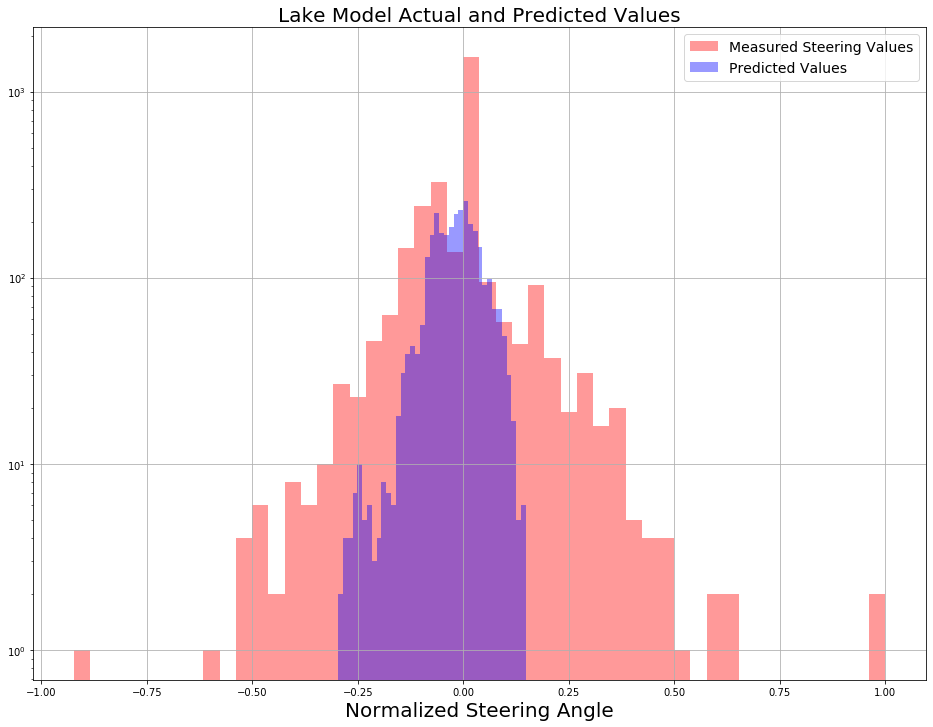

In [21]:
#Plot predicted steering angles with Lake-side model
plt.pyplot.figure(figsize=(16,12))
sns.distplot(y_test_sub, kde=False, color="r", label="Measured Steering Values")
sns.distplot(y_pred, kde=False, color="b", label="Predicted Values")
plt.pyplot.xlabel('Normalized Steering Angle', fontsize = 20)
plt.pyplot.title('Lake Model Actual and Predicted Values', fontsize = 20)
plt.pyplot.legend(fontsize = 14)
plt.pyplot.yscale('log')
plt.pyplot.grid(True)
plt.pyplot.show()